# Predicting popular conditions from drug reviews using Datasets and Transformers libraries

Inspired by: https://huggingface.co/course

<p><a href="https://colab.research.google.com/drive/12BigcqjIvFSQmeE1m4AP6fHzfZm62icd?usp=sharing", target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"></a>&nbsp;to run on GPU (Runtime > Change Runtime Type > GPU)</p>

The preprocessing and training take a while. Reload cells are provided.

Jump to:

[Reload preprocessed data](#reload-preprocessed-data)

[Reload model](#reload-model)

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import numpy as np
import pandas as pd
import html
import re
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datasets import load_dataset, Features, ClassLabel, Sequence, Value
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report

## Download, import and inspect the data

Source: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

The data is split into a train (75%) a test (25%) partition and stored in two .tsv files.

**Attribute Information:**

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

In [2]:
with urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip") as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall()

In [7]:
drug_dataset = load_dataset('csv', data_files={'train': "drugsComTrain_raw.tsv", 'test': "drugsComTest_raw.tsv"}, delimiter='\t')
drug_dataset

Using custom data configuration default-8b6d4d5425c56eae


100%|██████████| 2/2 [00:00<00:00, 407.00it/s]


Dataset csv downloaded and prepared to C:\Users\federico trifoglio\.cache\huggingface\datasets\csv\default-8b6d4d5425c56eae\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 13.33it/s]


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In [8]:
drug_sample = drug_dataset['train'].shuffle(seed=42).select(range(1000))
drug_sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

## Cleaning

- rename ID column
- remove examples where condition is missing
- conditions all lower case
- split conditions separated by comma
- convert HTML characters to unicode

The `Datasets.map` method with `batched=True` allows to apply a `lambda` function to 1,000 examples at once.

When `batched=True`, `map()` passes a list of examples to the `lambda` function and it must return a list of values.

So the call usually has this structure:

```
Datasets.map(lambda x: {'column_name': [ex.foo() for ex in x['column_name']]}, batched=True)
```

In [9]:
drug_dataset = drug_dataset.rename_column(original_column_name='Unnamed: 0', new_column_name='patient_id')
drug_dataset = drug_dataset.filter(lambda x: x['condition'] is not None)
drug_dataset = drug_dataset.map(lambda x: {'condition': [o.lower() for o in x['condition']]}, batched=True)
drug_dataset = drug_dataset.map(lambda x: {'condition_split': [o.lower().split(', ') for o in x['condition']]}, batched=True)
drug_dataset = drug_dataset.map(lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True)

100%|██████████| 54/54 [00:01<00:00, 46.61ba/s]


## Feature engineering

- add review length
- tokenization for [BERT cased](https://huggingface.co/bert-base-cased)

In [10]:
drug_dataset = drug_dataset.map(lambda x: {'review_length': [len(o.split()) for o in x['review']]}, batched=True)

100%|██████████| 54/54 [00:01<00:00, 41.19ba/s]


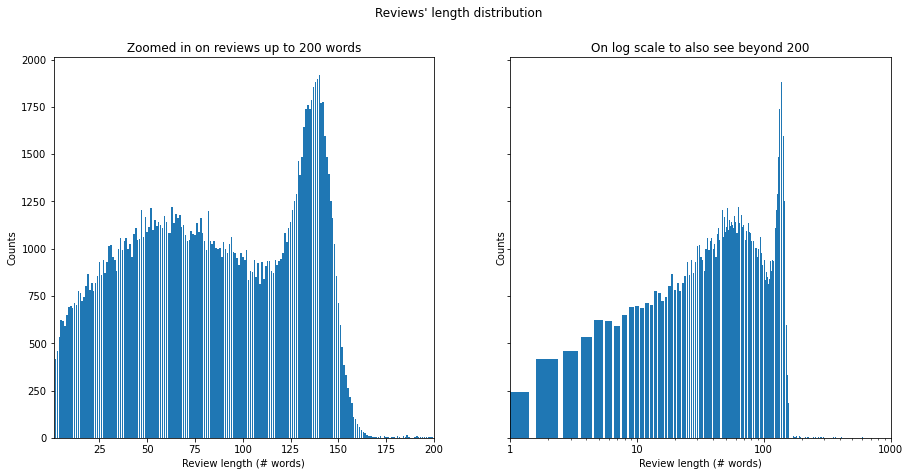

In [11]:
def plot_review_length(dt):
  """
  Plot distribution of reviews' word-lengths
  First plot has fixed x axis from 1 to 200
  The second plot has fixed log(x) axis from 1 to 1000
  
  Parameters:
  -----------
  dt: datasets.DatasetDict 
    with train key and review_length as a feature
  """
  # convert to data frame
  dt.set_format('pandas')
  train_df = dt['train'][:]
  frequencies = (
      train_df['review_length']
      .value_counts(sort=False)
      .sort_index()
  )
  # reconvert to Datasets
  dt.reset_format() 

  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7), sharey=True)
  fig.suptitle("Reviews' length distribution")
  ax1.bar(frequencies.index, frequencies.values)
  ax1.set_xlim(1,200)
  ax1.set_xlabel("Review length (# words)")
  ax1.set_ylabel("Counts")
  ax1.set_title("Zoomed in on reviews up to 200 words")
  ax2.bar(frequencies.index, frequencies.values)
  ax2.set_xscale('log')
  ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
  ax2.set_xlim(1,1000)
  ax2.set_xlabel("Review length (# words)")
  ax2.set_ylabel("Counts")
  ax2.set_title("On log scale to also see beyond 200")

plot_review_length(drug_dataset)

- remove reviews with less than 30 words

100%|██████████| 54/54 [00:01<00:00, 44.33ba/s]


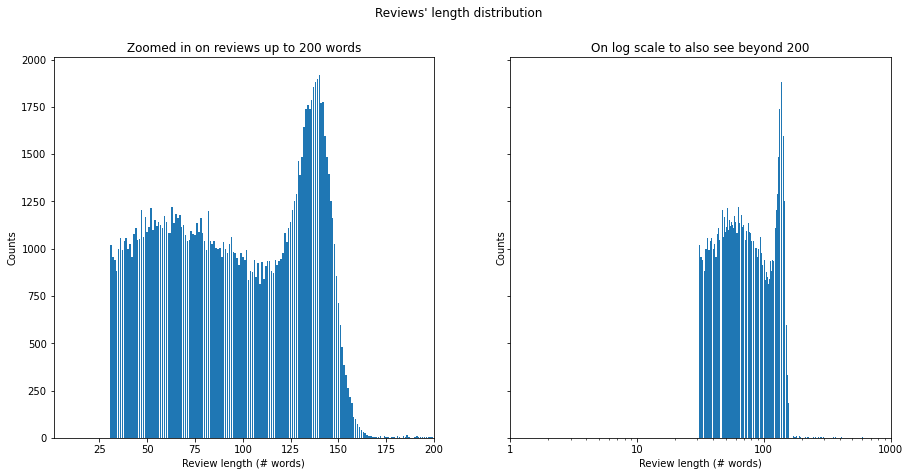

In [12]:
drug_dataset = drug_dataset.filter(lambda x: x['review_length'] > 30)

plot_review_length(drug_dataset)

In [8]:
pretrained_model = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
print(f"Max #tokens for {tokenizer.name_or_path} is {tokenizer.model_max_length}")

Max #tokens for bert-base-cased is 512


In [14]:
def tokenize_and_split(examples):
    """
    Create additional examples from overflowing tokens
    """
    result = tokenizer(
        examples["review"],
        truncation=True,
        return_overflowing_tokens=True
    )
    sample_map = result.pop('overflow_to_sample_mapping')
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

print(f"Length before tokenize_and_split: train={len(drug_dataset['train'])}, test={len(drug_dataset['test'])}")
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
print(f"Length before tokenize_and_split: train={len(tokenized_dataset['train'])}, test={len(tokenized_dataset['test'])}")

Length before tokenize_and_split: train=138514, test=46108


100%|██████████| 47/47 [00:12<00:00,  3.77ba/s]

Length before tokenize_and_split: train=138579, test=46121


Let's take a look at how data get tokenized for BERT.

In [29]:
example_tokens = tokenizer.convert_ids_to_tokens(tokenized_dataset['train']['input_ids'][0][:10]) + \
                 ['...'] + \
                 tokenizer.convert_ids_to_tokens(tokenized_dataset['train']['input_ids'][0][-10:])
print(*[str(i) + " " * (len(tk)-len(str(i))) if len(str(i)) <= len(tk) else " " * len(tk) for i, tk in enumerate(example_tokens)], sep="|")
print(*example_tokens, sep="|")

0    |1|2 |3  |4 |5      |6      |7  |8     |9   |10 |11|12 |13  |14|15 |16  |17       | | |20   
[CLS]|"|My|son|is|halfway|through|his|fourth|week|...|so|far|this|is|the|most|effective|.|"|[SEP]


BERT uses WordPiece tokenization (vocabulary size of 30,000). And since it was trained on a 'next sentence prediction' task a training example is of the form 

```
[CLS] Sentence A [SEP] Sentence B [SEP]
```

But when using BERT for a downstream classification task we will only add `[CLS]` and `[SEP]` at the begging and the end, respectively.

`[PAD]` is added when the examples in one training batch are not of the same length.



## Create labels

We want to predict a patient condition based on the content of their review.

In [16]:
conditions = [item for sublist in tokenized_dataset['train']['condition_split'] for item in sublist]
conditions = Counter(conditions)
top_conditions = [condition for condition, frequency in conditions.most_common()[:10]]
print(f"There are {len(conditions)} conditions.\nThe 10 most commons are {', '.join(top_conditions)}.")

There are 818 conditions.
The 10 most commons are birth control, depression, acne, anxiety, pain, bipolar disorde, weight loss, obesity, insomnia, adhd.


We add "other" so we have 11 possible labels to predict.

In [17]:
top_conditions.append("other")

In [18]:
def label_encoder(condition):
    """
    Return integer from 0 to 10 where 0 
    is birth control, 1 depression etc and 10 is other
    """
    regex_conditions = [
        bool(re.search("birth control", condition)),
        bool(re.search("depression", condition)),
        bool(re.search("pain", condition)),
        bool(re.search("anxiety", condition)),
        bool(re.search("acne", condition)),
        bool(re.search("bipolar disorde", condition)),
        bool(re.search("insomnia", condition)),
        bool(re.search("weight loss", condition)),
        bool(re.search("obesity", condition)),
        bool(re.search("adhd", condition))
    ]
    choices = range(10)
    return int(np.select(regex_conditions, choices, default=10))

Put it all together.

In [19]:
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=top_conditions)
})
tokenized_dataset = tokenized_dataset.remove_columns(['date', 'condition_split', 'drugName', 'patient_id', 'rating', 'review', 'review_length', 'usefulCount'])
tokenized_dataset = tokenized_dataset.rename_column(
    original_column_name='condition', new_column_name='label'
)
tokenized_dataset = tokenized_dataset.map(lambda x: {'label': [label_encoder(o) for o in x['label']]}, batched=True, features=features)
tokenized_dataset['train'].features

100%|██████████| 47/47 [00:13<00:00,  3.55ba/s]


{'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'label': ClassLabel(num_classes=11, names=['birth control', 'depression', 'acne', 'anxiety', 'pain', 'bipolar disorde', 'weight loss', 'obesity', 'insomnia', 'adhd', 'other'], names_file=None, id=None)}

## Training

We split the train data set into train-dev (80/20) and keep the test for later.

In [30]:
drug_dataset_preproc = tokenized_dataset['train'].train_test_split(train_size=0.8, seed=42)
drug_dataset_preproc['validation'] = drug_dataset_preproc.pop('test')
drug_dataset_preproc['test'] = tokenized_dataset['test']
# drug_dataset_preproc.save_to_disk('drug-reviews')

Flattening the indices: 100%|██████████| 28/28 [00:07<00:00,  3.72ba/s]


##### Reload preprocessed data

In [3]:
# from datasets import load_from_disk
# drug_dataset_preproc = load_from_disk('drug-reviews')
# pretrained_model = 'bert-base-cased'
# tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
# top_condition = ['birth control', 'depression', 'acne', 'anxiety', 
#                  'pain', 'bipolar disorde', 'weight loss', 'obesity', 
#                  'insomnia', 'adhd', 'other']

In [5]:
N_tra = len(drug_dataset_preproc['train'])
N_dev = len(drug_dataset_preproc['validation'])
N_tes = len(drug_dataset_preproc['test'])

We can use the `to_tf_dataset()` method to wrap the dataset with a `tf.data.Dataset`, which are natively understood by Keras. This means a `tf.data.Dataset` object can be iterated over to yield batches of data, and can be passed directly to methods like `model.fit()`.

The `collate_fn` argument specifies a data collator that will batch each processed example and apply padding.

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

batch_size = 8

# select 20% of the data to keep the training "short" (~7 hours on CPU)
tf_train_dataset = drug_dataset_preproc['train'].shuffle(seed=42).\
    select(range(N_tra // 5)).to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols=['labels'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_validation_dataset = drug_dataset_preproc['validation'].shuffle(seed=42).\
    select(range(N_dev // 5)).to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols=['labels'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

Loading cached shuffled indices for dataset at drug-reviews/validation\cache-7fb2514cdab54e2a.arrow


We now define the downstream classification model to train BERT on.

In [32]:
model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=11)

Downloading: 100%|██████████| 502M/502M [02:03<00:00, 4.26MB/s]
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We train for just 1 epoch (2771 minibatches) using Adam optimizer on accuracy with a decaying learning rate.

In [46]:
num_epochs = 1
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [47]:
%%time

model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)
# model_path = "./models/drugs-bert-base-cased"
# model.save_pretrained(model_path)

2771/2771 [==============================] - 26883s 10s/step - loss: 0.7354 - accuracy: 0.7560 - val_loss: 0.4837 - val_accuracy: 0.8275
CPU times: total: 2d 1h 25min 55s
Wall time: 7h 28min 3s


#### Reload model

In [12]:
# pretrained_model = 'bert-base-cased'
# model_path = "./models/drugs-bert-base-cased"
# model = TFAutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
# tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
# from datasets import load_from_disk
# drug_dataset_preproc = load_from_disk("drug-reviews")
# N_tes = len(drug_dataset_preproc['test'])
# batch_size = 8
# top_conditions = ['birth control', 'depression', 'acne', 'anxiety', 
#                   'pain', 'bipolar disorde', 'weight loss', 'obesity', 
#                   'insomnia', 'adhd', 'other']


In [7]:
small_test = drug_dataset_preproc['test'].shuffle(seed=42).select(range(N_tes // 5))
tf_test_dataset = small_test.to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols=['labels'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)
test_preds = model.predict(tf_test_dataset)
class_preds = np.argmax(test_preds['logits'], axis=1)

In [13]:
cm = confusion_matrix(small_test['label'], class_preds, normalize='pred')

cm_df = pd.DataFrame(cm,
                     index = pd.Index(top_conditions, name="Actual:"), 
                     columns = pd.MultiIndex.from_product([[""], top_conditions], names=["","Predicted:"])
                     ).round(2)
cm_df[cm_df == 0] = ''

print("Precision confusion matrix")
cm_df

Precision confusion matrix


\
Predicted:      birth control depression  acne anxiety  pain bipolar disorde   
Actual:                                                                        
birth control            0.88                           0.07                   
depression                          0.65  0.01    0.18                  0.12   
acne                                      0.78                                 
anxiety                              0.1          0.61                  0.04   
pain                     0.01                           0.87                   
bipolar disorde                     0.05          0.02                  0.63   
weight loss                                       0.01                  0.02   
obesity                                                                        
insomnia                                                                       
adhd                                0.01          0.01                  0.02   
other                    0.11       0.18  0.21    0.17  0.06            0.17   

                                                          
Predicted:      weight loss obesity insomnia  adhd other  
Actual:                                                   
birth control                  0.01                 0.01  
depression             0.05                   0.03  0.02  
acne                                                0.03  
anxiety                0.03                   0.02  0.01  
pain                                                      
bipolar disorde        0.01                   0.01  0.01  
weight loss            0.76                         0.01  
obesity                        0.53     0.31  0.01  0.01  
insomnia                       0.39     0.67              
adhd                   0.01                   0.85        
other                  0.12    0.07     0.02  0.08   0.9

In [14]:
cr = classification_report(small_test['label'], class_preds, target_names=top_conditions)
print(cr)

                 precision    recall  f1-score   support

  birth control       0.88      0.95      0.91      1833
     depression       0.65      0.59      0.62       578
           acne       0.78      0.72      0.75       462
        anxiety       0.61      0.75      0.67       519
           pain       0.87      0.88      0.87       346
bipolar disorde       0.63      0.67      0.65       239
    weight loss       0.76      0.84      0.80       201
        obesity       0.53      0.70      0.60       221
       insomnia       0.67      0.38      0.49       224
           adhd       0.85      0.83      0.84       194
          other       0.90      0.86      0.88      4407

       accuracy                           0.83      9224
      macro avg       0.74      0.74      0.73      9224
   weighted avg       0.83      0.83      0.83      9224

